In [2]:
# importing the libraries
import os
import sys
import pandas as pd
import torch
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import  glob
import time
import seaborn as sns
import albumentations
import math
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder# creating instance of one-hot-encoder

from models.models import Myresnext50
from train.train_classification import trainer_classification
from utils.utils import configure_optimizers
from Datasets.DataLoader import Img_DataLoader
from tqdm import tqdm
### PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils import data
from torchvision import transforms

In [3]:
import matplotlib.pyplot as plt

In [4]:
X_train = glob.glob('/data/aa-ssun2-cmp/DL_region/data/*/*')
X_val = glob.glob('/data/aa-ssun2-cmp/DL_region/data/*/*')

labels = [x.split('/')[-2] for x in X_train]
cell_types = set(labels)

cell_types = list(cell_types)
cell_types.sort()

cell_types_df = pd.DataFrame(cell_types, columns=['Types'])# converting type of columns to 'category'
cell_types_df['Types'] = cell_types_df['Types'].astype('category')# Assigning numerical values and storing in another column
cell_types_df['Types_Cat'] = cell_types_df['Types'].cat.codes

enc = OneHotEncoder(handle_unknown='ignore')# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(cell_types_df[['Types_Cat']]).toarray())# merge with main df bridge_df on key values
cell_types_df = cell_types_df.join(enc_df)

image_names  = [x.split('/')[-1] for x in glob.glob('/data/aa-ssun2-cmp/heme_seg/AWS/WSI_patches/1082320222035195_tiles_files/*')] #

In [5]:
x_list = []
y_list = []
for _names in image_names:
    x_list.append(int(_names.split('_')[0]))
    y_list.append(int(_names.split('_')[1].split('.')[0]))

In [6]:
max(y_list)

35

In [7]:
len(glob.glob('/data/aa-ssun2-cmp/heme_seg/AWS/WSI_patches/1082320222035195_tiles_files/*'))

3744

In [12]:
canvas = np.zeros((35*50, 103*50,3)).astype('uint8')
for y in tqdm(range(max(x_list))):
    for x in range(max(y_list)):
        img = Image.open('/data/aa-ssun2-cmp/heme_seg/AWS/WSI_patches/1082320222035195_tiles_files/'+str(y)+'_'+str(x)+'.jpeg')
        canvas[x*50:(x+1)*50,
              y*50:(y+1)*50,:] = np.array(img.resize((50,50)))

100%|██████████| 103/103 [00:17<00:00,  6.03it/s]


In [13]:
orig_image = canvas.copy()
#plt.imshow(orig_image[850:1210, 1200:1800])
plt.imshow(orig_image)
plt.xticks([])
plt.yticks([])
plt.savefig('Results/Grant_panel/slide_orig.pdf')

In [15]:
cropped_img_list = []
for y in tqdm(range(max(x_list)+1)):
    for x in range(max(y_list)+1):
        cropped_img_list.append('/data/aa-ssun2-cmp/heme_seg/AWS/WSI_patches/1082320222035195_tiles_files/'+str(y)+'_'+str(x)+'.jpeg')
        

100%|██████████| 104/104 [00:00<00:00, 7491.89it/s]


In [16]:
len(cropped_img_list)

3744

In [17]:
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d')
My_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3)

checkpoint_PATH = '/data/aa-ssun2-cmp/DL_region/checkpoints/checkpoint_best_iteration3.ckpt'
checkpoint = torch.load(checkpoint_PATH)

from collections import OrderedDict
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        
        name = k[7:] # remove `module.`
        
        new_state_dict[name] = v
    
    return new_state_dict

checkpoint  = remove_data_parallel(checkpoint['model_state_dict'])

My_model.load_state_dict(checkpoint, strict=True)

Using cache found in /home/aa-ssun2-cmp/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [18]:
transform_pipeline = albumentations.Compose(
        [
            albumentations.Normalize(mean=(0.5637, 0.5637, 0.5637), std=(0.2381, 0.2381, 0.2381)),

        ]
    )

In [19]:
from tqdm import tqdm
My_model = My_model.cuda().eval()
Orig_img = Img_DataLoader(img_list= cropped_img_list, split='compute',df= cell_types_df,transform = transform_pipeline)
shuffle = False
print('test')
dataloader = DataLoader(Orig_img, batch_size=16, num_workers=2, shuffle=shuffle)


for i, _batch in enumerate(tqdm(dataloader)):
    
    if i == 0:

        images = _batch["image"].cuda()
        #label = _batch["label"]
        x_cor    = [int(x.split('/')[-1].split('_')[0]) for x in _batch['ID']]
        y_cor    = [int(x.split('/')[-1].split('_')[-1].split('.')[0]) for x in _batch['ID']]
        pred_prob = My_model(images)

        pred_prob = torch.flatten(pred_prob, start_dim=1).detach().cpu().numpy()
    else:
        images = _batch["image"].cuda()
        #_label = _batch["label"]
        _x_cor    = [int(x.split('/')[-1].split('_')[0]) for x in _batch['ID']]
        _y_cor    = [int(x.split('/')[-1].split('_')[-1].split('.')[0]) for x in _batch['ID']]
        
        _pred_prob = My_model(images)
        
        _pred_prob = torch.flatten(_pred_prob, start_dim=1).detach().cpu().numpy()
        
        x_cor = x_cor + _x_cor
        y_cor = y_cor + _y_cor
        pred_prob = np.concatenate((pred_prob, _pred_prob))
  

test


  0%|          | 0/234 [00:00<?, ?it/s]/home/aa-ssun2-cmp/anaconda3/envs/Harry_Img/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 234/234 [00:30<00:00,  7.79it/s]


In [20]:
df_res = pd.DataFrame(data= pred_prob, columns = ['adequate', 'blood', 'clot'])
df_res['x'] = x_cor
df_res['y'] = y_cor
df_res['cord'] = list(zip(x_cor,y_cor))

In [26]:
heatmap = np.zeros((36,104))
for ((x,y),z) in zip(df_res['cord'].tolist(), df_res['adequate'].tolist()):
    heatmap[y, x] = z
#heatmap = 1- heatmap
plt.figure(figsize = (10.3,3.5))
sns.heatmap(heatmap, cbar=False, vmax=1, vmin=0, yticklabels=False, xticklabels=False, cmap="Greens")
plt.savefig('./Results/Grant_panel/slide_adequate.pdf')

/home/aa-ssun2-cmp/anaconda3/envs/Harry_Img/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rainbow").copy()
  


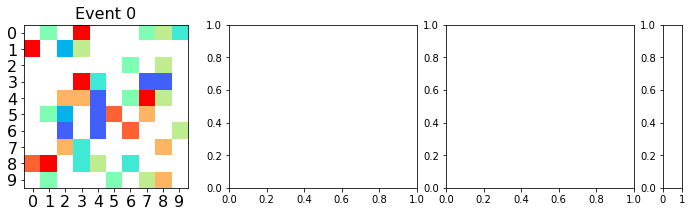

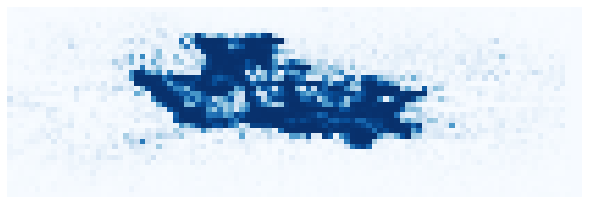

In [27]:
heatmap = np.zeros((36,104))
for ((x,y),z) in zip(df_res['cord'].tolist(), df_res['clot'].tolist()):
    heatmap[y, x] = z
plt.figure(figsize = (10.3,3.5))
sns.heatmap(heatmap, cbar=False, vmax=1, vmin=0, yticklabels=False, xticklabels=False, cmap="Blues")
plt.savefig('./Results/Grant_panel/slide_clot.pdf')

In [28]:
heatmap = np.zeros((36,104))
for ((x,y),z) in zip(df_res['cord'].tolist(), df_res['blood'].tolist()):
    heatmap[y, x] = z
plt.figure(figsize = (10.3,3.5))
sns.heatmap(heatmap, cbar=False, vmax=1, vmin=0, yticklabels=False, xticklabels=False, cmap="Oranges")
plt.savefig('./Results/Grant_panel/slide_blood.pdf')

In [109]:
heatmap = np.zeros((36,104))
for ((x,y),z) in zip(df_res['cord'].tolist(), df_res['blood'].tolist()):
    heatmap[y, x] = z
plt.figure(figsize = (10.3,3.5))
sns.heatmap(heatmap, cbar=False, vmax=1, vmin=0, yticklabels=False, xticklabels=False)


<AxesSubplot:>

([], [])

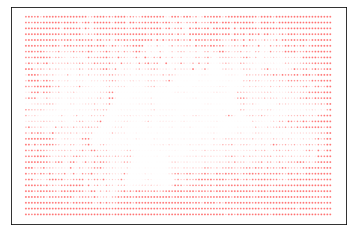

In [83]:
plt.scatter(df_res['x'], df_res['y'], s=df_res['blood'], c="red", alpha=0.4)
plt.xticks([])
plt.yticks([])

([], [])

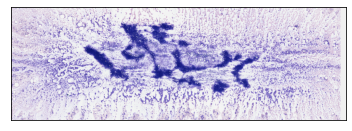

In [84]:
orig_image = canvas.copy()
#plt.imshow(orig_image[850:1210, 1200:1800])
plt.imshow(orig_image)
plt.xticks([])
plt.yticks([])

<AxesSubplot:>

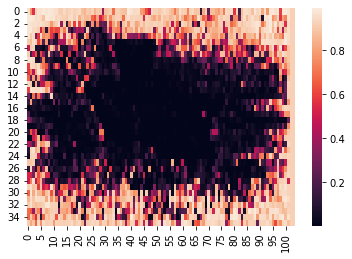

In [95]:
import seaborn as sns
sns.heatmap(heatmap)

In [81]:
len(crop_x_lists)

3605

In [72]:
max(crop_x_lists)

595

5

355

In [78]:
df_res

adequate     blood      clot    x   y
0     0.041193  0.961233  0.003124    0   0
1     0.023400  0.978232  0.001768    0   1
2     0.026794  0.974812  0.002300    0   2
3     0.032654  0.969279  0.002654    0   3
4     0.035555  0.965899  0.003289    0   4
...        ...       ...       ...  ...  ..
3600  0.079011  0.918633  0.007445  102  30
3601  0.079011  0.918633  0.007445  102  31
3602  0.079011  0.918633  0.007445  102  32
3603  0.079011  0.918633  0.007445  102  33
3604  0.079011  0.918633  0.007445  102  34

[3605 rows x 5 columns]

In [80]:
ratio = df_res['clot'].tolist()
ratio = [1 if x>0.9 else 0 for x in ratio]
crop_x_lists = []
crop_y_lists = []
for y in list(range(5,350,10)):
    for x in list(range(5,1030+5,10)):
        crop_x_lists.append(x)
        crop_y_lists.append(y)
        
dx, dy = 10,10

# Custom (rgb) grid color
grid_color = [0,0,0]
canvas_cropped = orig_image
# Modify the image to include the grid
canvas_cropped[:,::dy,:] = grid_color
canvas_cropped[::dx,:,:] = grid_color

plt.scatter(crop_x_lists, crop_y_lists, marker="x", s=[40*x for x in ratio])
plt.imshow(canvas_cropped)
plt.xticks([])
plt.yticks([])

([], [])

120

(1000, 1000, 3)